In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [2]:
X_train = pd.read_csv("hw11t3v2_train.txt", sep="\t", header=None)
print X_train.shape
X_train.head()

(500, 7)


,0,1,2,3,4,5,6
0,-6.747,-1.055,5.720,23.663,107.605,-3.826,-4.797
1,-2.665,0.690,-2.680,20.478,119.372,-0.973,-1.202
2,-0.841,-1.328,-49.175,-27.190,22.926,0.651,2.921
3,0.020,1.058,22.570,36.423,118.271,-1.278,0.585
4,-2.699,-0.505,-73.750,-40.474,36.016,-1.406,-0.159


In [3]:
X_test = pd.read_csv("hw11t3v2_test.txt", sep="\t", header=None)
print X_test.shape
X_test.head()

(50, 7)


,0,1,2,3,4,5,6
0,-3.030,-0.382,-3.549,13.136,82.869,-0.432,0.376
1,1.746,2.549,-4.976,-1.426,9.452,-1.760,0.692
2,0.203,2.315,-23.088,4.343,102.793,-2.459,0.362
3,-2.572,1.787,-0.616,22.117,121.083,-3.101,-1.044
4,-1.008,-0.049,36.409,22.452,-4.490,0.702,2.365


In [4]:
y_train = pd.read_csv("hw11t3v2_target.txt", sep="\t", header=None)
y_test = pd.read_csv("hw11t3v2_target_test.txt", sep="\t", header=None)

Изобразим проекции обучающей выборки на 1,2 и 3-х мерные пространства.

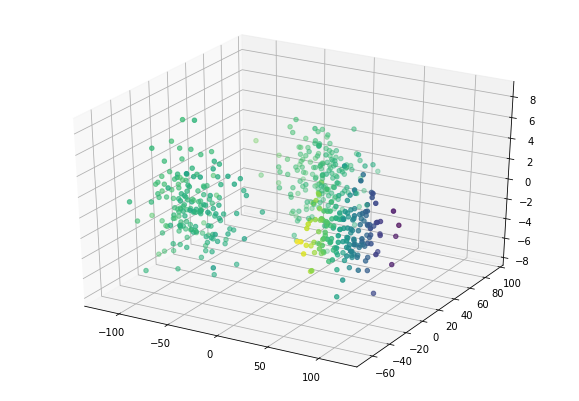

In [5]:
pca = PCA(n_components=3)
X_train_transformed = pca.fit_transform(X_train)

plt.close()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_transformed[:,0], X_train_transformed[:,1], X_train_transformed[:,2], c=y_train)
plt.show()

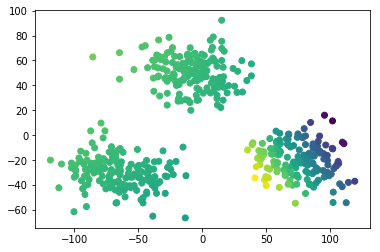

In [6]:
pca = PCA(n_components=2)
X_train_transformed = pca.fit_transform(X_train)
plt.scatter(X_train_transformed[:,0], X_train_transformed[:,1], c=y_train)
plt.show()

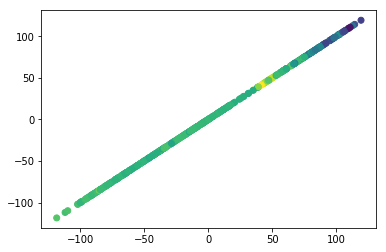

In [7]:
pca = PCA(n_components=1)
X_train_transformed = pca.fit_transform(X_train)
plt.scatter(X_train_transformed, X_train_transformed, c=y_train)
plt.show()

Видно 3 сблансированных кластера при проекции в 3-х и 2-мерное пространство, имеющие, каждый в отдельности, хороший отклик с меткой. При проецировании на 1 компоненту кластеры смешиваются.

Протестируем модель, обученную на исходной выборке.

In [8]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_predicted = regressor.predict(X_test)
print mean_squared_error(y_test, y_predicted)

467403.870446


Теперь спроецируем выборку в 2-мерное пространство и построим линейную модель для каждого кластера.

In [9]:
pca = PCA(n_components=2)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

kmeans = KMeans(3)
clusters_train = kmeans.fit_predict(X_train_transformed)
clusters_test = kmeans.predict(X_test_transformed)

regressors = [LinearRegression() for _ in range(3)]
for cluster_id, regressor in enumerate(regressors):
    mask = clusters_train == cluster_id
    regressor.fit(X_train_transformed[mask], y_train[mask])
    
y_predicted = []
for x, cluster_id in zip(X_test_transformed, clusters_test):
    y_predicted.append(regressors[cluster_id].predict(x.reshape(1, -1))[0])

print mean_squared_error(y_test, y_predicted)

45303.2890103


Как видим, ошибка на тесте уменьшилась в 10 раз за счёт использования знания о кластерах.

Также попробуем обучить одну линейную модель, используя номер кластера как дополнительный признак. Ожидаем уведить качество хуже, чем у предыдущей сложной модели, но лучше бейзлайна.

In [10]:
regressor = LinearRegression()
regressor.fit(np.hstack((X_train_transformed, clusters_train.reshape(-1, 1))), y_train)
y_predicted = regressor.predict(np.hstack((X_test_transformed, clusters_test.reshape(-1, 1))))

print mean_squared_error(y_test, y_predicted)

312199.707289


Так и есть.